# Equity intraday volatility
Clean notebook version for the project.  
This copy keeps code and removes any class references.


In [127]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdatesv
import os
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display
import matplotlib.dates as mdates
from zoneinfo import ZoneInfo

In [72]:
def prepare_session(mbo, symbol, session_date, tz='America/New_York', conversion=True):
    # ts_event est en ns → datetime UTC
    mbo = mbo[mbo['symbol'] == symbol].copy()
    mbo['ts'] = pd.to_datetime(mbo['ts_event'], unit='ns', utc=True)
    mbo['ts_et'] = mbo['ts'].dt.tz_convert(tz)

    d = pd.to_datetime(session_date).date()
    sod = pd.Timestamp(d, tz=tz) + pd.Timedelta(hours=9, minutes=30)
    eod = pd.Timestamp(d, tz=tz) + pd.Timedelta(hours=16)
    mbo = mbo[(mbo['ts_et'] >= sod) & (mbo['ts_et'] < eod)]
    mbo = mbo.sort_values(['ts_et','sequence'])
    mbo['minute'] = mbo['ts_et'].dt.floor('min')           # minute ET
    mbo['px'] = mbo['price'] / 1e9  if conversion else mbo['price']                   # $ (prix en nanos → dollars)
    return mbo

# MICROSOFT

In [75]:
msft = pd.read_csv('xnas-itch-20250722.mbo.csv')
msft = prepare_session(msft, 'MSFT', '2025-07-22')
msft.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,price,size,channel_id,order_id,flags,ts_in_delta,sequence,symbol,ts,ts_et,minute,px
46603,1753191000021822751,1753191000021654248,160,2,10888,A,A,512700000000,500,0,47205007,128,168503,24561161,MSFT,2025-07-22 13:30:00.021654248+00:00,2025-07-22 09:30:00.021654248-04:00,2025-07-22 09:30:00-04:00,512.70
46604,1753191000021987531,1753191000021818987,160,2,10888,A,B,509400000000,500,0,47205335,128,168544,24561277,MSFT,2025-07-22 13:30:00.021818987+00:00,2025-07-22 09:30:00.021818987-04:00,2025-07-22 09:30:00-04:00,509.40
46605,1753191000023352003,1753191000023162260,160,2,10888,A,B,510320000000,100,0,47207939,128,189743,24562225,MSFT,2025-07-22 13:30:00.023162260+00:00,2025-07-22 09:30:00.023162260-04:00,2025-07-22 09:30:00-04:00,510.32
46606,1753191000026769160,1753191000026594466,160,2,10888,C,B,508200000000,500,0,44642903,128,174694,24564702,MSFT,2025-07-22 13:30:00.026594466+00:00,2025-07-22 09:30:00.026594466-04:00,2025-07-22 09:30:00-04:00,508.20
46607,1753191000027246602,1753191000027066368,160,2,10888,A,B,508500000000,500,0,47211439,128,180234,24565079,MSFT,2025-07-22 13:30:00.027066368+00:00,2025-07-22 09:30:00.027066368-04:00,2025-07-22 09:30:00-04:00,508.50


In [77]:
orders = {}  # order_id -> (side, px, qty)
levels_bid = defaultdict(int)  # px -> qty totale
levels_ask = defaultdict(int)
recs = []

def best(lvls, is_bid):
    ks = [p for p,q in lvls.items() if q > 0]
    if not ks: return (None, 0)
    p_best = max(ks) if is_bid else min(ks)
    return p_best, lvls[p_best]

for r in tqdm(msft.itertuples(index=False), total=len(msft)):
    act, oid, side, px, sz = r.action, int(r.order_id), r.side, float(r.px), int(r.size)

    if act in ('A','F'):  # Add
        # par robustesse, si l'oid existe déjà on le retire d'abord
        if oid in orders:
            s_old, p_old, q_old = orders.pop(oid)
            (levels_bid if s_old=='B' else levels_ask)[p_old] -= q_old
        orders[oid] = (side, px, sz)
        (levels_bid if side=='B' else levels_ask)[px] += sz

    elif act == 'C':      # Cancel (réduction) — souvent agrège aussi les exécutions
        if oid in orders:
            s_old, p_old, q_old = orders[oid]
            dq = min(sz, q_old)
            q_new = q_old - dq
            if s_old=='B': levels_bid[p_old] -= dq
            else: levels_ask[p_old] -= dq
            if q_new > 0:
                orders[oid] = (s_old, p_old, q_new)
            else:
                orders.pop(oid, None)

    elif act == 'R':      # Replace (prix et/ou qty)
        if oid in orders:
            s_old, p_old, q_old = orders[oid]
            # retirer complètement l'ancien
            if s_old=='B': levels_bid[p_old] -= q_old
            else: levels_ask[p_old] -= q_old
        # puis enregistrer le nouveau (px, sz)
        orders[oid] = (side, px, sz)
        (levels_bid if side=='B' else levels_ask)[px] += sz

    # 'T' (print) n'affecte pas le carnet ici; la diminution liée aux exécutions passe via 'C'

    # snapshot L1 après l'event
    bb, bq = best(levels_bid, True)
    aa, aq = best(levels_ask, False)
    if bb is None or aa is None:
        continue
    spread = aa - bb
    recs.append((r.ts, bb, aa, bq, aq, spread))

l1 = pd.DataFrame(recs, columns=['ts','best_bid','best_ask','bid_depth','ask_depth','spread'])
l1['rel_spread'] = l1['spread'] / ((l1['best_bid'] + l1['best_ask'])/2)
l1.head()

100%|██████████| 1319351/1319351 [06:14<00:00, 3527.49it/s]


,ts,best_bid,best_ask,bid_depth,ask_depth,spread,rel_spread
0,2025-07-22 13:30:00.021818987+00:00,509.40,512.7,500,500,3.30,0.006457
1,2025-07-22 13:30:00.023162260+00:00,510.32,512.7,100,500,2.38,0.004653
2,2025-07-22 13:30:00.026594466+00:00,510.32,512.7,100,500,2.38,0.004653
3,2025-07-22 13:30:00.027066368+00:00,510.32,512.7,100,500,2.38,0.004653
4,2025-07-22 13:30:00.027216122+00:00,510.32,512.7,100,500,2.38,0.004653


In [141]:
# CELL 1 — imports, config, and source detection (displays a config table)

# --- CONFIG: adjust these to your data ---
TS_IS_UTC   = True                 # False if your 'ts' is already ET
TRADING_DAY = "2025-07-22"         # e.g. "YYYY-MM-DD" or None to keep all days

# --- Detect a likely input DataFrame (or set SRC yourself) ---
SRC = None
for name in [ "l1",]:
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        SRC = globals()[name]
        SRC_NAME = name
        break
if SRC is None:
    raise NameError("Set your input L1 DataFrame to a variable (e.g. `your_l1_df`) "
                    "with columns at least ['ts','best_bid','best_ask'] and re-run this cell.")

# Show a tiny config table
cfg_tbl = pd.DataFrame({
    "Parameter": ["Source DF", "TS_IS_UTC", "TRADING_DAY", "Rows", "Columns"],
    "Value": [SRC_NAME, TS_IS_UTC, TRADING_DAY, len(SRC), list(SRC.columns)]
})
display(cfg_tbl)



,Parameter,Value
0,Source DF,l1
1,TS_IS_UTC,True
2,TRADING_DAY,2025-07-22
3,Rows,1319350
4,Columns,"[ts, best_bid, best_ask, bid_depth, ask_depth,..."


In [142]:
# CELL 2 — time helpers + ET/RTH/day filtering (displays head())

def ensure_ts_et(df: pd.DataFrame, ts_col: str = "ts", ts_is_utc: bool = True) -> pd.DataFrame:
    out = df.copy()
    if ts_col not in out.columns:
        raise ValueError(f"Timestamp column '{ts_col}' not found.")
    s = pd.to_datetime(out[ts_col], errors="coerce")
    if ts_is_utc:
        if s.dt.tz is None: s = s.dt.tz_localize("UTC")
        else:               s = s.dt.tz_convert("UTC")
        out["ts_et"] = s.dt.tz_convert("US/Eastern")
    else:
        if s.dt.tz is None: s = s.dt.tz_localize("US/Eastern")
        else:               s = s.dt.tz_convert("US/Eastern")
        out["ts_et"] = s
    return out

def filter_rth(df: pd.DataFrame) -> pd.DataFrame:
    et = df["ts_et"].dt.tz_convert("US/Eastern")
    m = ((et.dt.hour > 9) | ((et.dt.hour == 9) & (et.dt.minute >= 30))) & (et.dt.hour < 16)
    return df.loc[m].reset_index(drop=True)

def filter_trading_day(df: pd.DataFrame, trading_day: str | None) -> pd.DataFrame:
    if not trading_day: return df
    d = df.copy()
    d["__date"] = d["ts_et"].dt.tz_convert("US/Eastern").dt.date.astype(str)
    out = d.loc[d["__date"] == trading_day].drop(columns="__date")
    return out.reset_index(drop=True)

# Apply to your source L1
df_ts = ensure_ts_et(SRC, ts_col="ts", ts_is_utc=TS_IS_UTC)
df_ts = filter_rth(df_ts)
df_ts = filter_trading_day(df_ts, TRADING_DAY)
df_ts = df_ts.sort_values("ts_et").reset_index(drop=True)

# Show a quick preview table
display(df_ts[["ts_et", "best_bid", "best_ask"]].head(8))


,ts_et,best_bid,best_ask
0,2025-07-22 09:30:00.021818987-04:00,509.40,512.7
1,2025-07-22 09:30:00.023162260-04:00,510.32,512.7
2,2025-07-22 09:30:00.026594466-04:00,510.32,512.7
3,2025-07-22 09:30:00.027066368-04:00,510.32,512.7
4,2025-07-22 09:30:00.027216122-04:00,510.32,512.7
5,2025-07-22 09:30:00.027711030-04:00,510.32,512.7
6,2025-07-22 09:30:00.027711487-04:00,510.32,512.7
7,2025-07-22 09:30:00.030092787-04:00,510.65,512.7


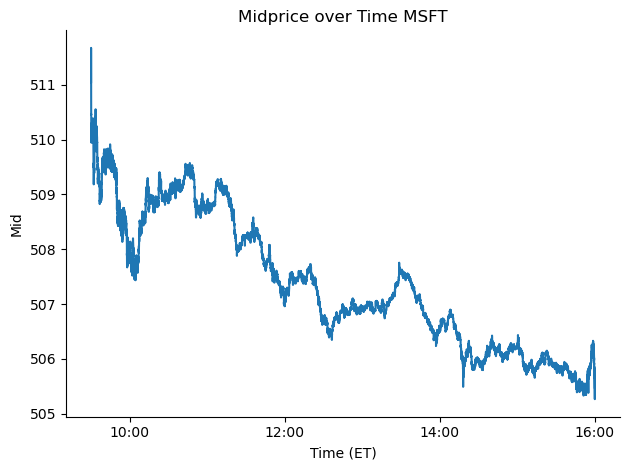

In [143]:
# CELL 3 — mid & log-mid (plots mid price)



l1_mid = df_ts[["ts_et", "best_bid", "best_ask"]].copy()
l1_mid["mid"] = (l1_mid["best_bid"] + l1_mid["best_ask"]) / 2.0
l1_mid["mid_log"] = np.log(l1_mid["mid"])

def setup_time_axis(ax, interval=2, tz="America/New_York"):
    tzinfo = ZoneInfo(tz)
    ax.xaxis.set_major_locator(mdates.HourLocator(tz=tzinfo, interval=interval))   # ET ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", tz=tzinfo))        # show HH:MM only
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

fig, ax = plt.subplots()
# ensure axis uses ET even if already ET
x = l1_mid["ts_et"].dt.tz_convert("America/New_York")
ax.plot(x, l1_mid["mid"])
ax.set_title("Midprice over Time MSFT")
ax.set_xlabel("Time (ET)")
ax.set_ylabel("Mid")
setup_time_axis(ax)
fig.tight_layout()
plt.show()


In [144]:
# CELL 4 — TSRV (10m, stride=2, multi-grid adaptive K) + diagnostics table

@dataclass
class TSRVConfig:
    stride: int = 2
    window_minutes: int = 10

def _choose_K(n: int) -> int:
    if n <= 1: return 2
    K = max(2, int(np.floor(n**(2/3))))
    return min(K, max(2, n-1)) if n >= 3 else 2

def tsrv_from_log_series(mid_log: pd.Series, K: int | None = None) -> float:
    x = mid_log.values
    n = x.size - 1
    if n <= 1:
        return np.nan
    if K is None:
        K = _choose_K(n)

    all_rv = np.sum(np.diff(x)**2)

    # average K-subgrid RV over K offsets
    terms = []
    for o in range(K):
        y = x[o:]
        if y.size <= K: break
        terms.append(np.sum((y[K:] - y[:-K])**2))
    if not terms:
        return np.nan

    Kavg = float(np.mean(terms))
    z = (n - K + 1) / K
    denom = 1.0 - (z / n)
    if denom <= 0 or not np.isfinite(denom):
        return Kavg
    return (Kavg - (z / n) * all_rv) / denom

def compute_tsrv_panel(l1: pd.DataFrame, cfg=TSRVConfig()) -> pd.DataFrame:
    s = l1[["ts_et","mid_log"]].copy().sort_values("ts_et").reset_index(drop=True)
    if cfg.stride > 1:
        s = s.iloc[::cfg.stride].reset_index(drop=True)
    s["win"] = s["ts_et"].dt.floor(f"{cfg.window_minutes}T")

    rows = []
    for w, g in s.groupby("win", sort=True):
        n = len(g)
        if n < 3:
            rows.append((w, np.nan, n, np.nan))
            continue
        K = _choose_K(n-1)  # n-1 returns
        v = tsrv_from_log_series(g["mid_log"], K=K)
        rows.append((w, v, n, K))

    panel = pd.DataFrame(rows, columns=["window_start","tsrv_10m","n_obs","K_used"]).sort_values("window_start")
    panel["rv_10m"] = np.sqrt(np.clip(panel["tsrv_10m"], 0, None))
    panel["rv_30m"] = panel["rv_10m"].rolling(3, min_periods=2).mean()
    panel["rv_60m"] = panel["rv_10m"].rolling(6, min_periods=3).mean()
    return panel.reset_index(drop=True)

panel = compute_tsrv_panel(l1_mid)

# Show diagnostics table
display(panel[["window_start", "n_obs", "K_used", "rv_10m"]].head(10))


/var/folders/vj/yrx5_jms7qzc2v6m8w5t89tm0000gn/T/ipykernel_37681/3163493211.py:43: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  s["win"] = s["ts_et"].dt.floor(f"{cfg.window_minutes}T")


,window_start,n_obs,K_used,rv_10m
0,2025-07-22 09:30:00-04:00,39560,1160,0.103710
1,2025-07-22 09:40:00-04:00,17767,680,0.036116
2,2025-07-22 09:50:00-04:00,32030,1008,0.059657
3,2025-07-22 10:00:00-04:00,21705,778,0.044171
4,2025-07-22 10:10:00-04:00,13507,567,0.028240
5,2025-07-22 10:20:00-04:00,11212,500,0.020664
6,2025-07-22 10:30:00-04:00,13802,575,0.020899
7,2025-07-22 10:40:00-04:00,18582,701,0.019791
8,2025-07-22 10:50:00-04:00,13018,553,0.022354
9,2025-07-22 11:00:00-04:00,13306,561,0.014671


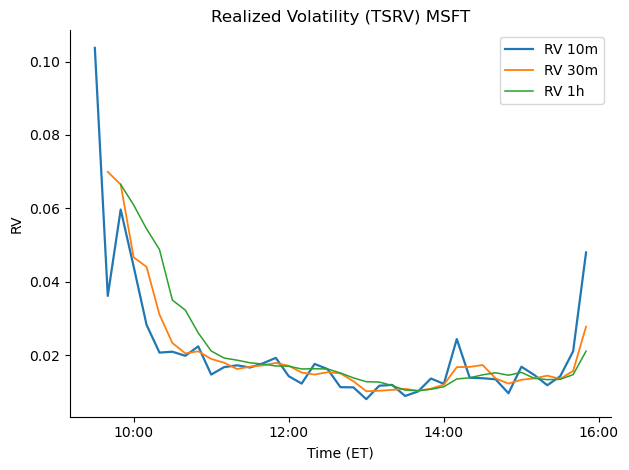

In [145]:
# CELL 5 — RV & activity plots


fig, ax = plt.subplots()
x = panel["window_start"].dt.tz_convert("America/New_York")  # ensure ET on the axis

ax.plot(x, panel["rv_10m"], label="RV 10m", linewidth=1.6)
ax.plot(x, panel["rv_30m"], label="RV 30m", linewidth=1.3)
ax.plot(x, panel["rv_60m"], label="RV 1h",  linewidth=1.1)

ax.set_title("Realized Volatility (TSRV) MSFT")
ax.set_xlabel("Time (ET)")
ax.set_ylabel("RV")
ax.legend()

setup_time_axis(ax, interval=2, tz="America/New_York")  # ← same helper as before
fig.tight_layout()
plt.show()


In [146]:
# CELL 6 — forecasting + results table

def chronological_split(X: pd.DataFrame, y: pd.Series, train_frac=2/3):
    n = len(y); cut = int(np.floor(train_frac*n))
    return X.iloc[:cut].values, X.iloc[cut:].values, y.iloc[:cut].values, y.iloc[cut:].values

def run_forecasts(panel: pd.DataFrame):
    df = panel.copy()
    df["rv_next"] = df["rv_10m"].shift(-1)

    # OLS
    ols = pd.concat([df[["rv_10m","rv_30m","rv_60m"]], df["rv_next"]], axis=1).dropna()

    # AR(6)
    for i in range(1,7):
        df[f"rv_lag{i}"] = df["rv_10m"].shift(i)
    ar6 = pd.concat([df[[f"rv_lag{i}" for i in range(1,7)]], df["rv_next"]], axis=1).dropna()

    metrics = {}

    if len(ols) > 10:
        Xtr,Xte,ytr,yte = chronological_split(ols[["rv_10m","rv_30m","rv_60m"]], ols["rv_next"])
        m = LinearRegression().fit(Xtr,ytr)
        p_train, p_test = m.predict(Xtr), m.predict(Xte)
        r2_train = m.score(Xtr, ytr)
        r2_test  = 1 - (np.sum((yte - p_test)**2) / np.sum((yte - np.mean(yte))**2))
        metrics["OLS"] = {
            "coefficients": {
                "intercept": float(m.intercept_),
                "rv_10m": float(m.coef_[0]),
                "rv_30m": float(m.coef_[1]),
                "rv_60m": float(m.coef_[2])
            },
            "in_sample": {
                "mse": float(mean_squared_error(ytr, p_train)),
                "mae": float(mean_absolute_error(ytr, p_train)),
                "r2": float(r2_train)
            },
            "out_of_sample": {
                "mse": float(mean_squared_error(yte, p_test)),
                "mae": float(mean_absolute_error(yte, p_test)),
                "r2": float(r2_test)
            },
            "n_train": int(len(ytr)), 
            "n_test": int(len(yte))
        }
        metrics["_OLS"] = (p_test, yte)

    if len(ar6) > 10:
        Xtr,Xte,ytr,yte = chronological_split(ar6[[f"rv_lag{i}" for i in range(1,7)]], ar6["rv_next"])
        m = LinearRegression().fit(Xtr,ytr)
        p_train, p_test = m.predict(Xtr), m.predict(Xte)
        r2_train = m.score(Xtr, ytr)
        r2_test  = 1 - (np.sum((yte - p_test)**2) / np.sum((yte - np.mean(yte))**2))
        metrics["AR6"] = {
            "coefficients": {
                "intercept": float(m.intercept_),
                "rv_lag1": float(m.coef_[0]),
                "rv_lag2": float(m.coef_[1]),
                "rv_lag3": float(m.coef_[2]),
                "rv_lag4": float(m.coef_[3]),
                "rv_lag5": float(m.coef_[4]),
                "rv_lag6": float(m.coef_[5])
            },
            "in_sample": {
                "mse": float(mean_squared_error(ytr, p_train)),
                "mae": float(mean_absolute_error(ytr, p_train)),
                "r2": float(r2_train)
            },
            "out_of_sample": {
                "mse": float(mean_squared_error(yte, p_test)),
                "mae": float(mean_absolute_error(yte, p_test)),
                "r2": float(r2_test)
            },
            "n_train": int(len(ytr)), 
            "n_test": int(len(yte))
        }
        metrics["_AR6"] = (p_test, yte)

    return metrics

def create_results_table(metrics):
    rows = []
    if "OLS" in metrics:
        ols = metrics["OLS"]
        rows += [
            ["OLS", "", ""],
            ["c (intercept)", f"{ols['coefficients']['intercept']:.2e}", ""],
            ["β_10m", f"{ols['coefficients']['rv_10m']:.3f}", ""],
            ["β_30m", f"{ols['coefficients']['rv_30m']:.3f}", ""],
            ["β_60m", f"{ols['coefficients']['rv_60m']:.3f}", ""],
            ["", "", ""],
            ["In-sample MSE", f"{ols['in_sample']['mse']:.2e}", ""],
            ["In-sample MAE", f"{ols['in_sample']['mae']:.2e}", ""],
            ["In-sample R²",  f"{ols['in_sample']['r2']:.3f}", ""],
            ["OOS MSE", f"{ols['out_of_sample']['mse']:.2e}", ""],
            ["OOS MAE", f"{ols['out_of_sample']['mae']:.2e}", ""],
            ["OOS R²",  f"{ols['out_of_sample']['r2']:.3f}", ""],
            ["", "", ""],
        ]
    if "AR6" in metrics:
        ar = metrics["AR6"]
        rows += [
            ["AR(6)", "", ""],
            ["c (intercept)", f"{ar['coefficients']['intercept']:.2e}", ""],
            ["φ1", f"{ar['coefficients']['rv_lag1']:.3f}", ""],
            ["φ2", f"{ar['coefficients']['rv_lag2']:.3f}", ""],
            ["φ3", f"{ar['coefficients']['rv_lag3']:.3f}", ""],
            ["φ4", f"{ar['coefficients']['rv_lag4']:.3f}", ""],
            ["φ5", f"{ar['coefficients']['rv_lag5']:.3f}", ""],
            ["φ6", f"{ar['coefficients']['rv_lag6']:.3f}", ""],
            ["", "", ""],
            ["In-sample MSE", f"{ar['in_sample']['mse']:.2e}", ""],
            ["In-sample MAE", f"{ar['in_sample']['mae']:.2e}", ""],
            ["In-sample R²",  f"{ar['in_sample']['r2']:.3f}", ""],
            ["OOS MSE", f"{ar['out_of_sample']['mse']:.2e}", ""],
            ["OOS MAE", f"{ar['out_of_sample']['mae']:.2e}", ""],
            ["OOS R²",  f"{ar['out_of_sample']['r2']:.3f}", ""],
        ]
    return pd.DataFrame(rows, columns=["Metric", "Value", "Notes"])

metrics = run_forecasts(panel)
results_table = create_results_table(metrics)
display(results_table)


,Metric,Value,Notes
0,OLS,,
1,c (intercept),5.53e-03,
2,β_10m,0.477,
3,β_30m,0.073,
4,β_60m,0.034,
5,,,
6,In-sample MSE,7.83e-06,
7,In-sample MAE,2.48e-03,
8,In-sample R²,0.856,
9,OOS MSE,1.01e-04,


# QUANTUM COMPUTING

In [147]:
quant = pd.read_csv('xnas-itch-20250730.mbo.csv')
quant = prepare_session(quant, 'QUBT', '2025-07-30')
quant.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,price,size,channel_id,order_id,flags,ts_in_delta,sequence,symbol,ts,ts_et,minute,px
12005,1753882200309653590,1753882200309482921,160,2,13391,F,B,15300000000,4,0,11159163,0,170669,27816295,QUBT,2025-07-30 13:30:00.309482921+00:00,2025-07-30 09:30:00.309482921-04:00,2025-07-30 09:30:00-04:00,15.3
12006,1753882200309653590,1753882200309482921,160,2,13391,C,B,15300000000,4,0,11159163,0,170669,27816295,QUBT,2025-07-30 13:30:00.309482921+00:00,2025-07-30 09:30:00.309482921-04:00,2025-07-30 09:30:00-04:00,15.3
12007,1753882200309653590,1753882200309482921,160,2,13391,F,B,15300000000,1,0,13736591,0,170669,27816296,QUBT,2025-07-30 13:30:00.309482921+00:00,2025-07-30 09:30:00.309482921-04:00,2025-07-30 09:30:00-04:00,15.3
12008,1753882200309653590,1753882200309482921,160,2,13391,C,B,15300000000,1,0,13736591,0,170669,27816296,QUBT,2025-07-30 13:30:00.309482921+00:00,2025-07-30 09:30:00.309482921-04:00,2025-07-30 09:30:00-04:00,15.3
12009,1753882200309653590,1753882200309482921,160,2,13391,F,B,15300000000,1,0,14681919,0,170669,27816297,QUBT,2025-07-30 13:30:00.309482921+00:00,2025-07-30 09:30:00.309482921-04:00,2025-07-30 09:30:00-04:00,15.3


In [148]:
orders = {}  # order_id -> (side, px, qty)
levels_bid = defaultdict(int)  # px -> qty totale
levels_ask = defaultdict(int)
recs = []

def best(lvls, is_bid):
    ks = [p for p,q in lvls.items() if q > 0]
    if not ks: return (None, 0)
    p_best = max(ks) if is_bid else min(ks)
    return p_best, lvls[p_best]

for r in tqdm(quant.itertuples(index=False), total=len(quant)):
    act, oid, side, px, sz = r.action, int(r.order_id), r.side, float(r.px), int(r.size)

    if act in ('A','F'):  # Add
        # par robustesse, si l'oid existe déjà on le retire d'abord
        if oid in orders:
            s_old, p_old, q_old = orders.pop(oid)
            (levels_bid if s_old=='B' else levels_ask)[p_old] -= q_old
        orders[oid] = (side, px, sz)
        (levels_bid if side=='B' else levels_ask)[px] += sz

    elif act == 'C':      # Cancel (réduction) — souvent agrège aussi les exécutions
        if oid in orders:
            s_old, p_old, q_old = orders[oid]
            dq = min(sz, q_old)
            q_new = q_old - dq
            if s_old=='B': levels_bid[p_old] -= dq
            else: levels_ask[p_old] -= dq
            if q_new > 0:
                orders[oid] = (s_old, p_old, q_new)
            else:
                orders.pop(oid, None)

    elif act == 'R':      # Replace (prix et/ou qty)
        if oid in orders:
            s_old, p_old, q_old = orders[oid]
            # retirer complètement l'ancien
            if s_old=='B': levels_bid[p_old] -= q_old
            else: levels_ask[p_old] -= q_old
        # puis enregistrer le nouveau (px, sz)
        orders[oid] = (side, px, sz)
        (levels_bid if side=='B' else levels_ask)[px] += sz

    # 'T' (print) n'affecte pas le carnet ici; la diminution liée aux exécutions passe via 'C'

    # snapshot L1 après l'event
    bb, bq = best(levels_bid, True)
    aa, aq = best(levels_ask, False)
    if bb is None or aa is None:
        continue
    spread = aa - bb
    recs.append((r.ts, bb, aa, bq, aq, spread))

l1_quant = pd.DataFrame(recs, columns=['ts','best_bid','best_ask','bid_depth','ask_depth','spread'])
l1_quant['rel_spread'] = l1_quant['spread'] / ((l1_quant['best_bid'] + l1_quant['best_ask'])/2)
l1_quant.head()

100%|██████████| 536154/536154 [00:39<00:00, 13538.93it/s]


,ts,best_bid,best_ask,bid_depth,ask_depth,spread,rel_spread
0,2025-07-30 13:30:00.309482921+00:00,15.29,15.3,30,276,0.01,0.000654
1,2025-07-30 13:30:00.309482921+00:00,15.29,15.3,35,276,0.01,0.000654
2,2025-07-30 13:30:00.309482921+00:00,15.29,15.3,35,276,0.01,0.000654
3,2025-07-30 13:30:00.309482921+00:00,15.29,15.3,45,276,0.01,0.000654
4,2025-07-30 13:30:00.309482921+00:00,15.29,15.3,45,276,0.01,0.000654


In [149]:
# CELL 1 — imports, config, and source detection (displays a config table)

# --- CONFIG: adjust these to your data ---
TS_IS_UTC   = True                 # False if your 'ts' is already ET
TRADING_DAY = "2025-07-30"         # e.g. "YYYY-MM-DD" or None to keep all days

# --- Detect a likely input DataFrame (or set SRC yourself) ---
SRC = None
for name in [ "l1_quant",]:
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        SRC = globals()[name]
        SRC_NAME = name
        break
if SRC is None:
    raise NameError("Set your input L1 DataFrame to a variable (e.g. `your_l1_df`) "
                    "with columns at least ['ts','best_bid','best_ask'] and re-run this cell.")

# Show a tiny config table
cfg_tbl = pd.DataFrame({
    "Parameter": ["Source DF", "TS_IS_UTC", "TRADING_DAY", "Rows", "Columns"],
    "Value": [SRC_NAME, TS_IS_UTC, TRADING_DAY, len(SRC), list(SRC.columns)]
})
display(cfg_tbl)

,Parameter,Value
0,Source DF,l1_quant
1,TS_IS_UTC,True
2,TRADING_DAY,2025-07-30
3,Rows,536130
4,Columns,"[ts, best_bid, best_ask, bid_depth, ask_depth,..."


In [150]:
def ensure_ts_et(df: pd.DataFrame, ts_col: str = "ts", ts_is_utc: bool = True) -> pd.DataFrame:
    out = df.copy()
    if ts_col not in out.columns:
        raise ValueError(f"Timestamp column '{ts_col}' not found.")
    s = pd.to_datetime(out[ts_col], errors="coerce")
    if ts_is_utc:
        if s.dt.tz is None: s = s.dt.tz_localize("UTC")
        else:               s = s.dt.tz_convert("UTC")
        out["ts_et"] = s.dt.tz_convert("US/Eastern")
    else:
        if s.dt.tz is None: s = s.dt.tz_localize("US/Eastern")
        else:               s = s.dt.tz_convert("US/Eastern")
        out["ts_et"] = s
    return out

def filter_rth(df: pd.DataFrame) -> pd.DataFrame:
    et = df["ts_et"].dt.tz_convert("US/Eastern")
    m = ((et.dt.hour > 9) | ((et.dt.hour == 9) & (et.dt.minute >= 30))) & (et.dt.hour < 16)
    return df.loc[m].reset_index(drop=True)

def filter_trading_day(df: pd.DataFrame, trading_day: str | None) -> pd.DataFrame:
    if not trading_day: return df
    d = df.copy()
    d["__date"] = d["ts_et"].dt.tz_convert("US/Eastern").dt.date.astype(str)
    out = d.loc[d["__date"] == trading_day].drop(columns="__date")
    return out.reset_index(drop=True)

# Apply to your source L1
df_ts = ensure_ts_et(SRC, ts_col="ts", ts_is_utc=TS_IS_UTC)
df_ts = filter_rth(df_ts)
df_ts = filter_trading_day(df_ts, TRADING_DAY)
df_ts = df_ts.sort_values("ts_et").reset_index(drop=True)

# Show a quick preview table
display(df_ts[["ts_et", "best_bid", "best_ask"]].head(8))


,ts_et,best_bid,best_ask
0,2025-07-30 09:30:00.309482921-04:00,15.29,15.3
1,2025-07-30 09:30:00.309482921-04:00,15.29,15.3
2,2025-07-30 09:30:00.309482921-04:00,15.29,15.3
3,2025-07-30 09:30:00.309482921-04:00,15.29,15.3
4,2025-07-30 09:30:00.309482921-04:00,15.29,15.3
5,2025-07-30 09:30:00.309482921-04:00,15.29,15.3
6,2025-07-30 09:30:00.309482921-04:00,15.29,15.3
7,2025-07-30 09:30:00.309482921-04:00,15.29,15.3


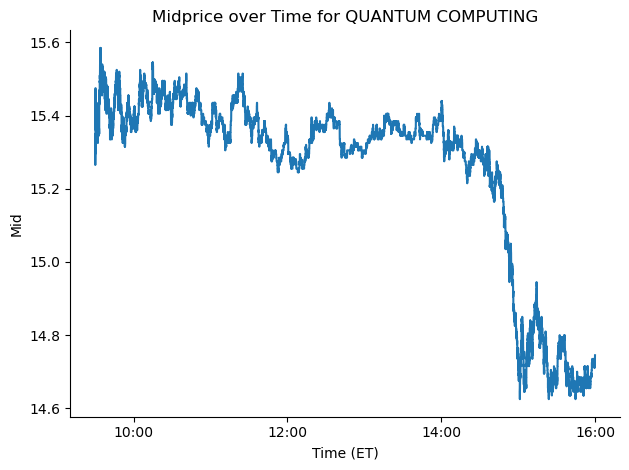

In [151]:


l1_mid = df_ts[["ts_et", "best_bid", "best_ask"]].copy()
l1_mid["mid"] = (l1_mid["best_bid"] + l1_mid["best_ask"]) / 2.0
l1_mid["mid_log"] = np.log(l1_mid["mid"])

def setup_time_axis(ax, interval=2, tz="America/New_York"):
    tzinfo = ZoneInfo(tz)
    ax.xaxis.set_major_locator(mdates.HourLocator(tz=tzinfo, interval=interval))   # ET ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", tz=tzinfo))        # show HH:MM only
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

fig, ax = plt.subplots()
# ensure axis uses ET even if already ET
x = l1_mid["ts_et"].dt.tz_convert("America/New_York")
ax.plot(x, l1_mid["mid"])
ax.set_title("Midprice over Time for QUANTUM COMPUTING")
ax.set_xlabel("Time (ET)")
ax.set_ylabel("Mid")
setup_time_axis(ax)
fig.tight_layout()
plt.show()


In [152]:
# CELL 4 — TSRV (10m, stride=2, multi-grid adaptive K) + diagnostics table

@dataclass
class TSRVConfig:
    stride: int = 2
    window_minutes: int = 10

def _choose_K(n: int) -> int:
    if n <= 1: return 2
    K = max(2, int(np.floor(n**(2/3))))
    return min(K, max(2, n-1)) if n >= 3 else 2

def tsrv_from_log_series(mid_log: pd.Series, K: int | None = None) -> float:
    x = mid_log.values
    n = x.size - 1
    if n <= 1:
        return np.nan
    if K is None:
        K = _choose_K(n)

    all_rv = np.sum(np.diff(x)**2)

    # average K-subgrid RV over K offsets
    terms = []
    for o in range(K):
        y = x[o:]
        if y.size <= K: break
        terms.append(np.sum((y[K:] - y[:-K])**2))
    if not terms:
        return np.nan

    Kavg = float(np.mean(terms))
    z = (n - K + 1) / K
    denom = 1.0 - (z / n)
    if denom <= 0 or not np.isfinite(denom):
        return Kavg
    return (Kavg - (z / n) * all_rv) / denom

def compute_tsrv_panel(l1: pd.DataFrame, cfg=TSRVConfig()) -> pd.DataFrame:
    s = l1[["ts_et","mid_log"]].copy().sort_values("ts_et").reset_index(drop=True)
    if cfg.stride > 1:
        s = s.iloc[::cfg.stride].reset_index(drop=True)
    s["win"] = s["ts_et"].dt.floor(f"{cfg.window_minutes}T")

    rows = []
    for w, g in s.groupby("win", sort=True):
        n = len(g)
        if n < 3:
            rows.append((w, np.nan, n, np.nan))
            continue
        K = _choose_K(n-1)  # n-1 returns
        v = tsrv_from_log_series(g["mid_log"], K=K)
        rows.append((w, v, n, K))

    panel = pd.DataFrame(rows, columns=["window_start","tsrv_10m","n_obs","K_used"]).sort_values("window_start")
    panel["rv_10m"] = np.sqrt(np.clip(panel["tsrv_10m"], 0, None))
    panel["rv_30m"] = panel["rv_10m"].rolling(3, min_periods=2).mean()
    panel["rv_60m"] = panel["rv_10m"].rolling(6, min_periods=3).mean()
    return panel.reset_index(drop=True)

panel = compute_tsrv_panel(l1_mid)

# Show diagnostics table
display(panel[["window_start", "n_obs", "K_used", "rv_10m"]].head(10))

/var/folders/vj/yrx5_jms7qzc2v6m8w5t89tm0000gn/T/ipykernel_37681/4142448188.py:43: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  s["win"] = s["ts_et"].dt.floor(f"{cfg.window_minutes}T")


,window_start,n_obs,K_used,rv_10m
0,2025-07-30 09:30:00-04:00,12780,546,0.347488
1,2025-07-30 09:40:00-04:00,6582,351,0.192198
2,2025-07-30 09:50:00-04:00,7241,374,0.133117
3,2025-07-30 10:00:00-04:00,7386,379,0.136464
4,2025-07-30 10:10:00-04:00,8354,411,0.163658
5,2025-07-30 10:20:00-04:00,7111,369,0.115717
6,2025-07-30 10:30:00-04:00,5886,325,0.085698
7,2025-07-30 10:40:00-04:00,6009,330,0.102581
8,2025-07-30 10:50:00-04:00,5085,295,0.078458
9,2025-07-30 11:00:00-04:00,6514,348,0.092471


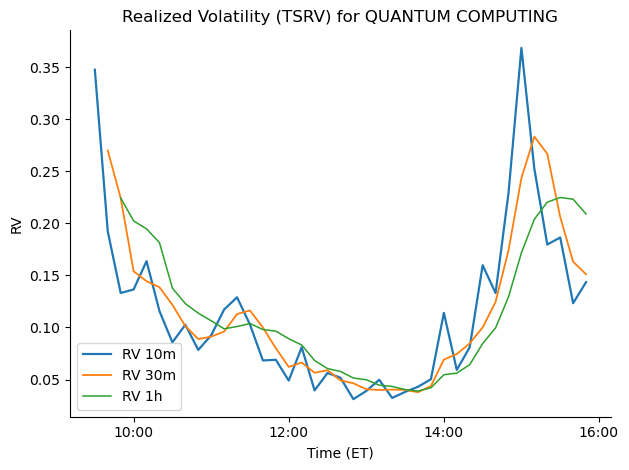

In [153]:
# CELL 5 — RV & activity plots

fig, ax = plt.subplots()
x = panel["window_start"].dt.tz_convert("America/New_York")  # ensure ET on the axis

ax.plot(x, panel["rv_10m"], label="RV 10m", linewidth=1.6)
ax.plot(x, panel["rv_30m"], label="RV 30m", linewidth=1.3)
ax.plot(x, panel["rv_60m"], label="RV 1h",  linewidth=1.1)

ax.set_title("Realized Volatility (TSRV) for QUANTUM COMPUTING")
ax.set_xlabel("Time (ET)")
ax.set_ylabel("RV")
ax.legend()

setup_time_axis(ax, interval=2, tz="America/New_York")  # ← same helper as before
fig.tight_layout()
plt.show()


In [154]:
# CELL 6 — forecasting + results table

def chronological_split(X: pd.DataFrame, y: pd.Series, train_frac=2/3):
    n = len(y); cut = int(np.floor(train_frac*n))
    return X.iloc[:cut].values, X.iloc[cut:].values, y.iloc[:cut].values, y.iloc[cut:].values

def run_forecasts(panel: pd.DataFrame):
    df = panel.copy()
    df["rv_next"] = df["rv_10m"].shift(-1)

    # OLS
    ols = pd.concat([df[["rv_10m","rv_30m","rv_60m"]], df["rv_next"]], axis=1).dropna()

    # AR(6)
    for i in range(1,7):
        df[f"rv_lag{i}"] = df["rv_10m"].shift(i)
    ar6 = pd.concat([df[[f"rv_lag{i}" for i in range(1,7)]], df["rv_next"]], axis=1).dropna()

    metrics = {}

    if len(ols) > 10:
        Xtr,Xte,ytr,yte = chronological_split(ols[["rv_10m","rv_30m","rv_60m"]], ols["rv_next"])
        m = LinearRegression().fit(Xtr,ytr)
        p_train, p_test = m.predict(Xtr), m.predict(Xte)
        r2_train = m.score(Xtr, ytr)
        r2_test  = 1 - (np.sum((yte - p_test)**2) / np.sum((yte - np.mean(yte))**2))
        metrics["OLS"] = {
            "coefficients": {
                "intercept": float(m.intercept_),
                "rv_10m": float(m.coef_[0]),
                "rv_30m": float(m.coef_[1]),
                "rv_60m": float(m.coef_[2])
            },
            "in_sample": {
                "mse": float(mean_squared_error(ytr, p_train)),
                "mae": float(mean_absolute_error(ytr, p_train)),
                "r2": float(r2_train)
            },
            "out_of_sample": {
                "mse": float(mean_squared_error(yte, p_test)),
                "mae": float(mean_absolute_error(yte, p_test)),
                "r2": float(r2_test)
            },
            "n_train": int(len(ytr)), 
            "n_test": int(len(yte))
        }
        metrics["_OLS"] = (p_test, yte)

    if len(ar6) > 10:
        Xtr,Xte,ytr,yte = chronological_split(ar6[[f"rv_lag{i}" for i in range(1,7)]], ar6["rv_next"])
        m = LinearRegression().fit(Xtr,ytr)
        p_train, p_test = m.predict(Xtr), m.predict(Xte)
        r2_train = m.score(Xtr, ytr)
        r2_test  = 1 - (np.sum((yte - p_test)**2) / np.sum((yte - np.mean(yte))**2))
        metrics["AR6"] = {
            "coefficients": {
                "intercept": float(m.intercept_),
                "rv_lag1": float(m.coef_[0]),
                "rv_lag2": float(m.coef_[1]),
                "rv_lag3": float(m.coef_[2]),
                "rv_lag4": float(m.coef_[3]),
                "rv_lag5": float(m.coef_[4]),
                "rv_lag6": float(m.coef_[5])
            },
            "in_sample": {
                "mse": float(mean_squared_error(ytr, p_train)),
                "mae": float(mean_absolute_error(ytr, p_train)),
                "r2": float(r2_train)
            },
            "out_of_sample": {
                "mse": float(mean_squared_error(yte, p_test)),
                "mae": float(mean_absolute_error(yte, p_test)),
                "r2": float(r2_test)
            },
            "n_train": int(len(ytr)), 
            "n_test": int(len(yte))
        }
        metrics["_AR6"] = (p_test, yte)

    return metrics

def create_results_table(metrics):
    rows = []
    if "OLS" in metrics:
        ols = metrics["OLS"]
        rows += [
            ["OLS", "", ""],
            ["c (intercept)", f"{ols['coefficients']['intercept']:.2e}", ""],
            ["β_10m", f"{ols['coefficients']['rv_10m']:.3f}", ""],
            ["β_30m", f"{ols['coefficients']['rv_30m']:.3f}", ""],
            ["β_60m", f"{ols['coefficients']['rv_60m']:.3f}", ""],
            ["", "", ""],
            ["In-sample MSE", f"{ols['in_sample']['mse']:.2e}", ""],
            ["In-sample MAE", f"{ols['in_sample']['mae']:.2e}", ""],
            ["In-sample R²",  f"{ols['in_sample']['r2']:.3f}", ""],
            ["OOS MSE", f"{ols['out_of_sample']['mse']:.2e}", ""],
            ["OOS MAE", f"{ols['out_of_sample']['mae']:.2e}", ""],
            ["OOS R²",  f"{ols['out_of_sample']['r2']:.3f}", ""],
            ["", "", ""],
        ]
    if "AR6" in metrics:
        ar = metrics["AR6"]
        rows += [
            ["AR(6)", "", ""],
            ["c (intercept)", f"{ar['coefficients']['intercept']:.2e}", ""],
            ["φ1", f"{ar['coefficients']['rv_lag1']:.3f}", ""],
            ["φ2", f"{ar['coefficients']['rv_lag2']:.3f}", ""],
            ["φ3", f"{ar['coefficients']['rv_lag3']:.3f}", ""],
            ["φ4", f"{ar['coefficients']['rv_lag4']:.3f}", ""],
            ["φ5", f"{ar['coefficients']['rv_lag5']:.3f}", ""],
            ["φ6", f"{ar['coefficients']['rv_lag6']:.3f}", ""],
            ["", "", ""],
            ["In-sample MSE", f"{ar['in_sample']['mse']:.2e}", ""],
            ["In-sample MAE", f"{ar['in_sample']['mae']:.2e}", ""],
            ["In-sample R²",  f"{ar['in_sample']['r2']:.3f}", ""],
            ["OOS MSE", f"{ar['out_of_sample']['mse']:.2e}", ""],
            ["OOS MAE", f"{ar['out_of_sample']['mae']:.2e}", ""],
            ["OOS R²",  f"{ar['out_of_sample']['r2']:.3f}", ""],
        ]
    return pd.DataFrame(rows, columns=["Metric", "Value", "Notes"])

metrics = run_forecasts(panel)
results_table = create_results_table(metrics)
display(results_table)

,Metric,Value,Notes
0,OLS,,
1,c (intercept),1.19e-02,
2,β_10m,0.392,
3,β_30m,0.094,
4,β_60m,0.246,
5,,,
6,In-sample MSE,3.62e-04,
7,In-sample MAE,1.52e-02,
8,In-sample R²,0.724,
9,OOS MSE,6.86e-03,
